# Shift Transformation

In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *
from exp.nb_AudioCommon import *
from exp.nb_DataBlock import *
from exp.nb_DataAugmentation import *

In [3]:
## The actual url is http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz
## but we need to strip off the extension otherwise fastai gets confused.
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
## Need this because the source tar file doesn't extract to its own folder
data_folder = datapath4file(url2name(data_url))
untar_data(data_url, dest=data_folder)

PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

64000


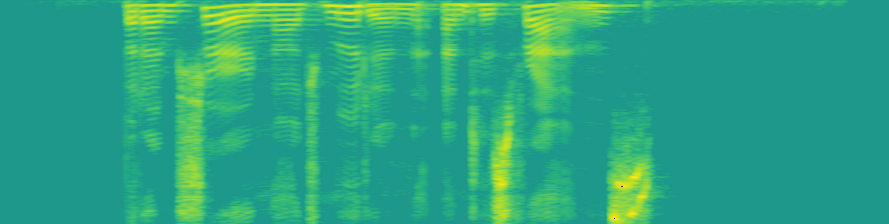

In [4]:
max_length = (4*16000)
print(max_length)
tfm_params = {
    'max_to_pad':max_length,
    'use_spectro':True, 
    'cache_spectro':True, 
    'to_db_scale':True,
    'f_max': 120
}

audios = (AudioList.from_folder(data_folder, **tfm_params)
         )
audios[10].show()

In [ ]:
def make_learner(data):
    newlayer = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    newlayer = newlayer.cuda() # Our layer should use cuda, since the rest of the model will.
    ## Standard learner
    learn = cnn_learner(data, models.resnet50, metrics=accuracy)
    ## Replace the first layer in the resnet18 model with our first layer
    learn.model[0][0] = newlayer
    learn.unfreeze()
    return learn

In [ ]:
## Regex to get the speaker ID in our file name (our label)
label_pattern = r'_([mf]\d+)_'
bs = 15
label_data = audios.split_by_rand_pct(0.2, seed=2).label_from_re(label_pattern)
label_data.train.x.tfm_args = tfm_params
label_data.valid.x.tfm_args = tfm_params
label_data

LabelLists;

Train: LabelList (3074 items)
x: AudioList
AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).
y: CategoryList
f0001,f0001,f0001,f0001,f0001
Path: /home/h/.fastai/data/ST-AEDS-20180100_1-OS;

Valid: LabelList (768 items)
x: AudioList
AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).
y: CategoryList
m0002,f0002,f0002,f0003,m0001
Path: /home/h/.fastai/data/ST-AEDS-20180100_1-OS;

Test: None

In [ ]:
def tfms_sr(resample_rate):
    return get_audio_transforms(resample_rate=resample_rate,
                            spectro=True,
                            mx_to_pad=100000,
                            white_noise=False,
                            modulate_volume=False,
                            random_cutout=False,
                            pad_with_silence=False,
                            pitch_warp=False,
                            down_and_up=False,
                            shift_max_pct=.6,
                            to_db_scale=True,
    )

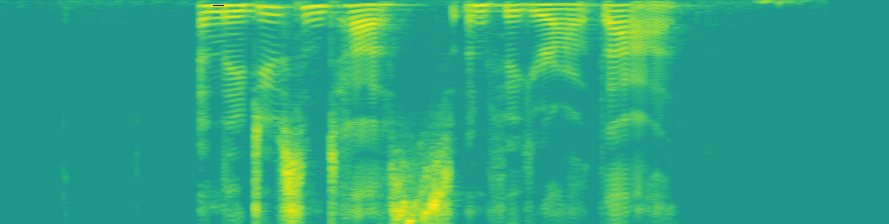

In [ ]:
db = label_data.databunch(bs=bs)
db.train_ds[1][0].show()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


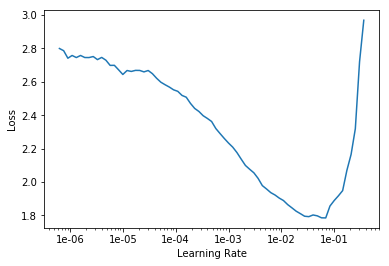

In [ ]:
learn = make_learner(db)
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, slice(1e-4, 4e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.468778,0.788216,0.781250,01:11


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.most_confused()